# Communication trials
The current setup is comprised of:
- Wavepro 804HD oscilloscope (LeCroy) - Ethernet (TCPIP0)
- ArbStudio 1102 arbitrary waveform generator (LeCroy) - USB
- B2916A power source (Agilent) - GPIB (23)
- B1104A pattern generator (Agilent) - GPIB (9)
- E36313A DC source (Keysight) - Not controlled

In [2]:
import serial
import serial.tools.list_ports
import pyvisa
import lecroyparser
import matplotlib.pyplot as plt

rm = pyvisa.ResourceManager()
print(rm.list_resources())

serial.tools.list_ports.comports(include_links=True)

# to deal with already initialised oscilloscope
lecroy = None

('TCPIP0::169.254.1.214::inst0::INSTR', 'GPIB1::9::INSTR', 'GPIB1::23::INSTR')


Power source

In [3]:
ps = rm.open_resource('GPIB1::23::INSTR')
print(ps.query('*IDN?'))

ps.write(':OUTP:LOW FLO')
ps.write(':OUTP:OFF:AUTO ON')
ps.write(':OUTP:PROT ON')
ps.write(':OUTP:RES:MODE FIX')
ps.write(':OUTP:RES:SHUN DEF')
ps.write(':SOUR:FUNC:MODE CURR')
ps.write(':SOUR:CURR:MODE FIX')
ps.write(':SOUR:CURR:LEV -1e-6')
ps.write(':DISP:ENAB OFF')
ps.write(':DISP:TEXT:DATA "pFREYA16"')
ps.write(':DISP:TEXT:STAT ON')
ps.write(':OUTP:STAT ON')

print(f'''
Low terminal: {ps.query(':OUTP:LOW?')[:-1]}
Auto output off: {ps.query(':OUTP:OFF:AUTO?')[:-1]}
Protection: {ps.query(':OUTP:PROT?')[:-1]}
Resistance mode: {ps.query(':OUTP:RES:MODE?')[:-1]}
Shunt resistance : {ps.query(':OUTP:RES:SHUN?')[:-1]}
Output current mode: {ps.query(':SOUR:CURR:MODE?')[:-1]}
Output current level: {ps.query(':SOUR:CURR:LEV?')[:-1]}
Output voltage range: {ps.query(':SOUR:VOLT:RANG?')[:-1]}
Output status: {ps.query(':OUTP:STAT?')[:-1]}
	''')

Agilent Technologies,B2961A,MY52350174,1.0.1236.9609


Low terminal: FLO
Auto output off: 1
Protection: 1
Resistance mode: FIX
Shunt resistance : +2.00000000E+009
Output current mode: FIX
Output current level: -1.00000000E-006
Output voltage range: +2.00000000E+000
Output status: 1
	


In [4]:
# recover from errors
ps.query(':SYST:ERR?')

'+0,"No error"\n'

Pattern generator

In [3]:
pg = rm.open_resource('GPIB1::9::INSTR')
print(pg.query('*IDN?'))

csa_reset_n_pattern = ''.join([f'{i}' for i in [1]*20 + [0]*980])
csa_reset_n_length = str(len(csa_reset_n_pattern))
csa_reset_n_length_length = str(len(str(len(csa_reset_n_pattern))))

pg.write('*RST')
pg.write(f':TRIG:COUN {csa_reset_n_length}')
pg.write(f':TRIG:SOUR INT')
pg.write(f':PULS:PER 15NS')
pg.write(f':PULS:DCYC1 50PCT')
pg.write(f':PULS:DCYC2 50PCT')
pg.write(f':PULS:TRAN1 3NS')
pg.write(f':PULS:TRAN2 3NS')
pg.write(':DIG:STIM:PATTERN:STAT ON')
pg.write(f':DIG:STIM:PATTERN:DATA1 #{csa_reset_n_length_length}{csa_reset_n_length}{csa_reset_n_pattern}')
pg.write(f':DIG:STIM:PATTERN:PRES2 2,{csa_reset_n_length}')
pg.write(f':DIG:STIM:PATTERN:DATA3 #{csa_reset_n_length_length}{csa_reset_n_length}{csa_reset_n_pattern}')
pg.write(f':DIG:STIM:SIGN1:FORM NRZ')
pg.write(f':DIG:STIM:SIGN2:FORM NRZ')
pg.write(':OUTP1:IMP:INT 50OHM')
pg.write(':OUTP1:IMP:EXT 100OHM')
pg.write(':OUTP2:IMP:INT 50OHM')
pg.write(':OUTP2:IMP:EXT 100OHM')
pg.write(':VOLT1:LEV:HIGH 1.2V')
pg.write(':VOLT1:LEV:LOW 0V')
pg.write(':VOLT2:LEV:HIGH 1.2V')
pg.write(':VOLT2:LEV:LOW 0V')
pg.write(':OUTP1 ON')
pg.write(':OUTP2 ON')

print(f'''
Number of pattern positions: {pg.query(':TRIG:COUN?')[:-1]}
Source of the trigger: {pg.query(':TRIG:SOUR?')[:-1]}
Period of the pulse: {pg.query(':PULS:PER?')[:-1]}
Duty cycle of the pulse: {pg.query(':PULS:DCYC1?')[:-1]}
Rise time of the pulse: {pg.query(':PULS:TRAN1?')[:-1]}
Type of pulse: PATTERN
CH1 data: 20 1's, 980 0's
CH2 data: as the clock
STRB data: 20 1's, 980 0's
Type of the pulse: {pg.query(':DIG:STIM:SIGN1:FORM?')[:-1]}
Internal impedance (source): {pg.query(':OUTP1:IMP:INT?')[:-1]}
External impedance (termination): {pg.query(':OUTP1:IMP:EXT?')[:-1]}
High level: {pg.query(':VOLT1:LEV:HIGH?')[:-1]}
Low level: {pg.query(':VOLT1:LEV:LOW?')[:-1]}
Output 1 status: {pg.query(':OUTP1?')[:-1]}
Output 2 status: {pg.query(':OUTP2?')[:-1]}
	''')

HEWLETT-PACKARD,HP81104A,DE38700607,REV 01.10.00


Number of pattern positions: +1000
Source of the trigger: IMM
Period of the pulse: +1.5000E-08
Duty cycle of the pulse: +5.0000E+01
Rise time of the pulse: +3.0000E-09
Type of pulse: PATTERN
CH1 data: 20 1's, 980 0's
CH2 data: as the clock
STRB data: 20 1's, 980 0's
Type of the pulse: NRZ
Internal impedance (source): +5.0000E+01
External impedance (termination): +1.0000E+02
High level: +1.2000E+00
Low level: +0.0000E+00
Output 1 status: 1
Output 2 status: 1
	


In [13]:
# recover from errors
pg.query(':SYST:ERR?')

'+0,"No error"\n'

Oscilloscope (raw VISA)

In [9]:
if lecroy is None:
	lecroy = rm.open_resource('TCPIP0::169.254.1.214::inst0::INSTR')
lecroy.write('COMM_HEADER OFF')
print(lecroy.query('*IDN?'))

# not setting the whole configuration for the time being, just doing the measurements
#print(lecroy.query('TEMPLATE?'))

LECROY,WP804HD,LCRY4608N02718,10.0.0



Le Croy Scope Data
Path: None - from bytes data
Endianness: <
Instrument: LECROYWP804HD
Instrument Number: 2718
Template Name: LECROY_2_3
Channel: Channel 1
WaveArrayCount: 20002
Vertical Coupling: DC50
Bandwidth Limit: off
Record Type: single_sweep
Processing: No Processing
TimeBase: 200 ns/div
TriggerTime: 2024-04-11 16:15:42.862



(-1.5, 0.1)

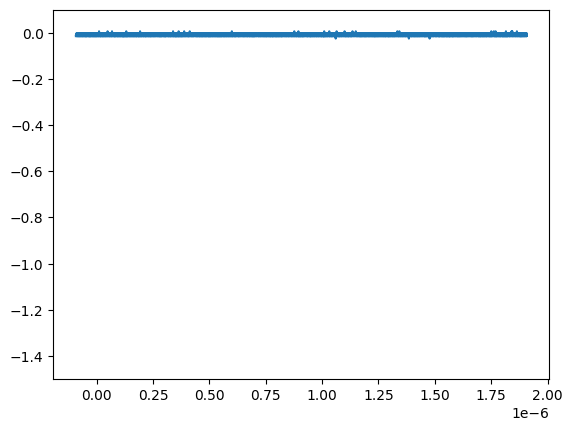

In [10]:
# oscilloscope waveform
data = lecroy.query_binary_values('C1:WF?', datatype='c')
data_bytes = b''.join(data)
data_osc = lecroyparser.ScopeData(data=data_bytes)
print(data_osc)
plt.plot(data_osc.x,data_osc.y)
plt.ylim(-1.5,.1)

In [59]:
# oscilloscope cursor values
data = lecroy.query('C1:CRVA? HREL')
print(data)

HREL,323E-9,-683.07E-3,8.16E-3,-702.57E-3,-2.1262E+6



In [34]:
# close connection for god's sake
ps.close()
pg.close()
lecroy.close()

AttributeError: 'NoneType' object has no attribute 'close'

Le Croy Scope Data
Path: E:/C1--C--00000.trc
Endianness: <
Instrument: LECROYWP804HD
Instrument Number: 2718
Template Name: LECROY_2_3
Channel: Channel 1
WaveArrayCount: 10002
Vertical Coupling: DC50
Bandwidth Limit: off
Record Type: single_sweep
Processing: No Processing
TimeBase: 100 ns/div
TriggerTime: 2024-03-25 18:54:44.13



(-1.5, 0.1)

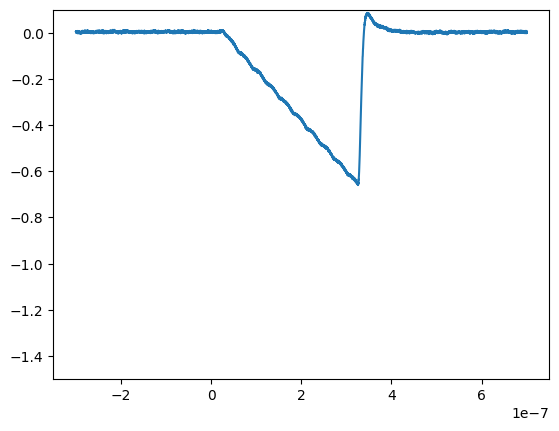

In [79]:
# oscilloscope waveform
data_osc = lecroyparser.ScopeData(path='E:/C1--C--00000.trc')
print(data_osc)
plt.plot(data_osc.x,data_osc.y)
plt.ylim(-1.5,.1)

Oscilloscope (python lib)

In [1]:
from TeledyneLeCroyPy import TeledyneLeCroyPy
import pandas as pd
import matplotlib.pyplot as plt

o = TeledyneLeCroyPy.LeCroyWaveRunner('TCPIP0::169.254.1.214::inst0::INSTR')

print(o.idn) # Check the connection.

LECROY,WP804HD,LCRY4608N02718,10.0.0


In [2]:
data = {}
for n_channel in [1,2]:
	data[n_channel] = o.get_channel(channel_name='F',n_channel=n_channel)

wf = []
for n_channel in data:
	for i,_ in enumerate(data[n_channel]['waveforms']):
		df = pd.DataFrame(_)
		df['n_segment'] = i
		df['n_channel'] = n_channel
		wf.append(df)
wf = pd.concat(wf)

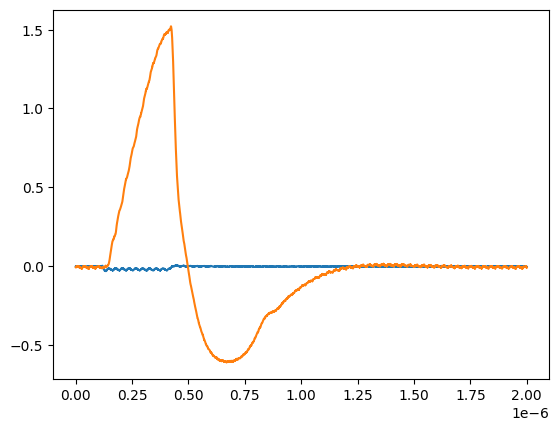

In [3]:
csa = wf.loc[wf['n_channel'] == 1]
shap = wf.loc[wf['n_channel'] == 2]

plt.plot(csa['Time (s)'], csa['Amplitude (V)'])
plt.plot(shap['Time (s)'], shap['Amplitude (V)'])

ArbStudio 1102

Remember to delete entry from seq and readd it

Total time: 44800
Total length: 6600, 6600, 6600


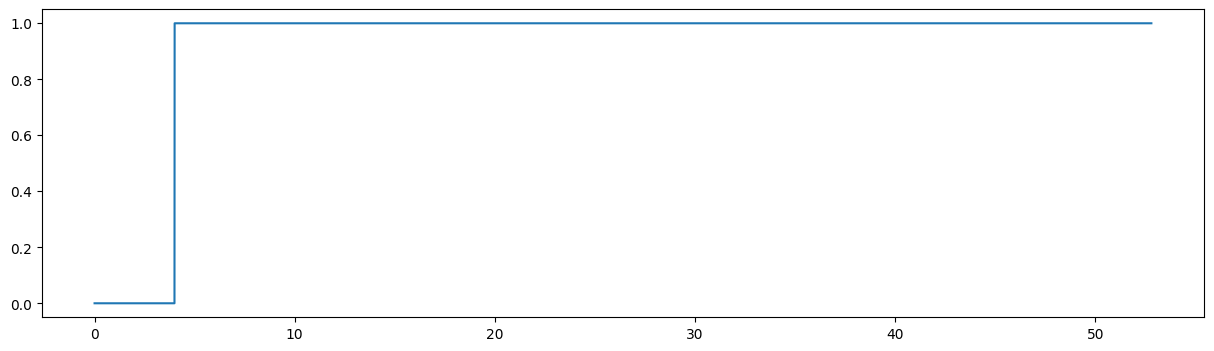

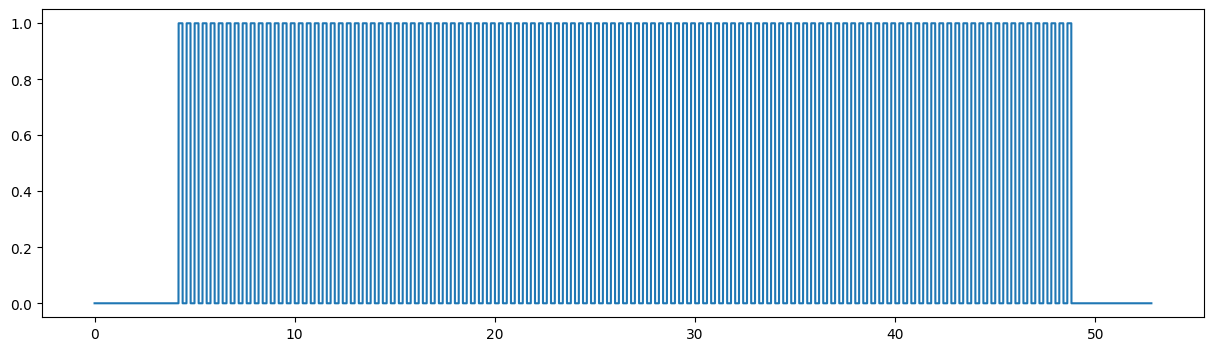

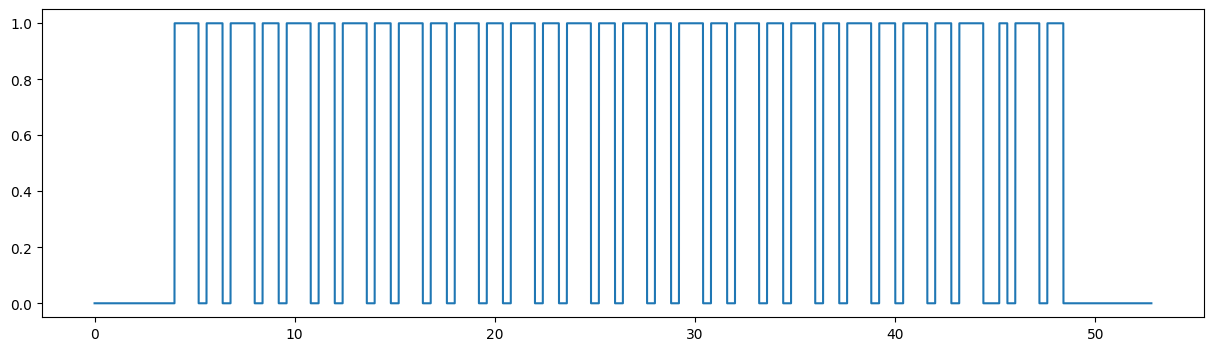

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# just generating csv for slow ctrl now
# csv is in format
# 	#1, #2, #3, ..., #18
#	b0_1, b0_2, b0_3, ..., b0_18
#	b1_1, b1_2, b1_3, ..., b1_18
#	...
#	b(N-1)_1, b(N-1)_2, b(N-1)_3, ..., b(N-1)_18
# using channel:
# 	#3 SLOW_CTRL_RESET_N
#	#4 SLOW_CTRL_IN
#	#2 SLOW_CTRL_CK
N_bit_slow_ctrl = 7
N_pixel = 16
N_bit_total = N_bit_slow_ctrl*N_pixel
timebase = 8 # ns
T_CK = 400 # ns
CK_T_SAMPLES = T_CK//timebase
total_time = T_CK*N_bit_total
CK_HITS = total_time//T_CK
print(f'Total time: {total_time}')

# IN_BITS = CSA_MODE_N0,CSA_MODE_N1,INJ_EN_N,SHAP_MODE1,SHAP_MODE0,CH_EN,INJ_MODE_N
# to be reversed
PIXEL_TO_TEST = 1
IN_BITS = [0,1,0,0,1,1,1]
if PIXEL_TO_TEST == 'all':
	IN_BITS_REV = IN_BITS[::-1]
	IN_BITSTREAM = IN_BITS_REV*N_pixel
else:
	IN_BITS_OFF = list.copy(IN_BITS)
	IN_BITS_OFF[2] = 1 # inj off for all channels
	IN_BITS_OFF_REV = IN_BITS_OFF[::-1]
	IN_BITSTREAM_OFF = IN_BITS_OFF_REV*N_pixel
	IN_BITSTREAM = IN_BITSTREAM_OFF
	IN_BITSTREAM[(N_pixel-1 - PIXEL_TO_TEST)*len(IN_BITS) + (len(IN_BITS)-1 - 2)] = 0 # inj on only on the one which we want

# everything needs to go to 0 except for reset_n, what really matters is that it is reset at the beginning
# so let's add some initialisation
N_INIT = 500
slow_ctrl_ck = [0]*N_INIT + ([0]*(CK_T_SAMPLES//2) + [1]*(CK_T_SAMPLES//2))*CK_HITS + [0]*N_INIT
slow_ctrl_reset_n = [0]*N_INIT + ([1]*CK_T_SAMPLES)*CK_HITS + [1]*N_INIT
slow_ctrl_in = [0]*N_INIT + list(np.array([[x]*CK_T_SAMPLES for x in IN_BITSTREAM]).flatten()) + [0]*N_INIT
print(f'Total length: {len(slow_ctrl_ck)}, {len(slow_ctrl_reset_n)}, {len(slow_ctrl_in)}')

plt.figure(figsize=(15,4))
plt.plot(np.arange(len(slow_ctrl_reset_n))*timebase/1000,slow_ctrl_reset_n)
plt.figure(figsize=(15,4))
plt.plot(np.arange(len(slow_ctrl_reset_n))*timebase/1000,slow_ctrl_ck)
plt.figure(figsize=(15,4))
plt.plot(np.arange(len(slow_ctrl_reset_n))*timebase/1000,slow_ctrl_in)

df = pd.DataFrame()
df['#2'] = slow_ctrl_ck
df['#3'] = slow_ctrl_reset_n
df['#4'] = slow_ctrl_in
df['#17'] = 0
df['#16'] = 0
conf_name = ''.join([str(x) for x in IN_BITS])
if PIXEL_TO_TEST == 'all':
	df.to_csv(f'arbstudio/slow_ctrl_{conf_name}_PIXALL.csv',index=False)
else:
	df.to_csv(f'arbstudio/slow_ctrl_{conf_name}_PIX{PIXEL_TO_TEST}.csv',index=False)

In [23]:
scr2 = slow_ctrl_ck

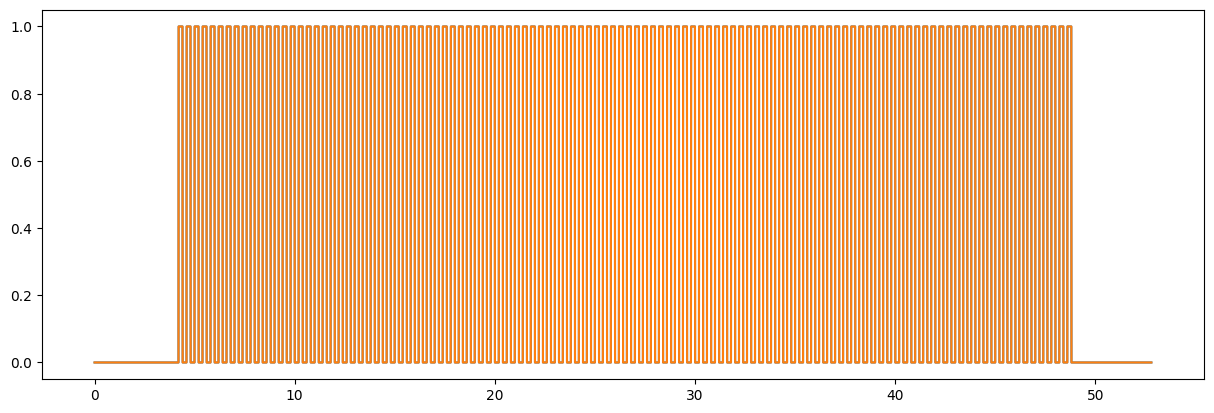

In [24]:
fig, ax = plt.subplots()
fig.set_figwidth(15)
ax.plot(np.arange(len(scr1))*timebase/1000,scr1)
ax.plot(np.arange(len(scr2))*timebase/1000,scr2)

Total time: 2800
Total length: 1350, 1350, 1350


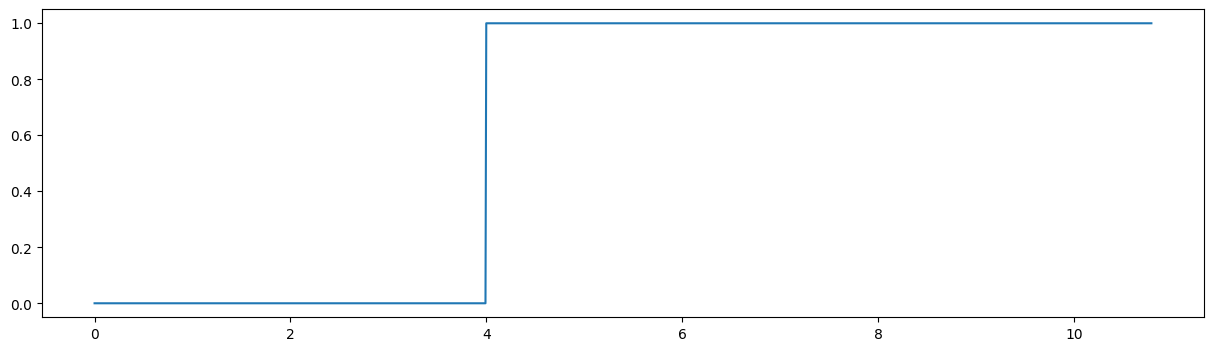

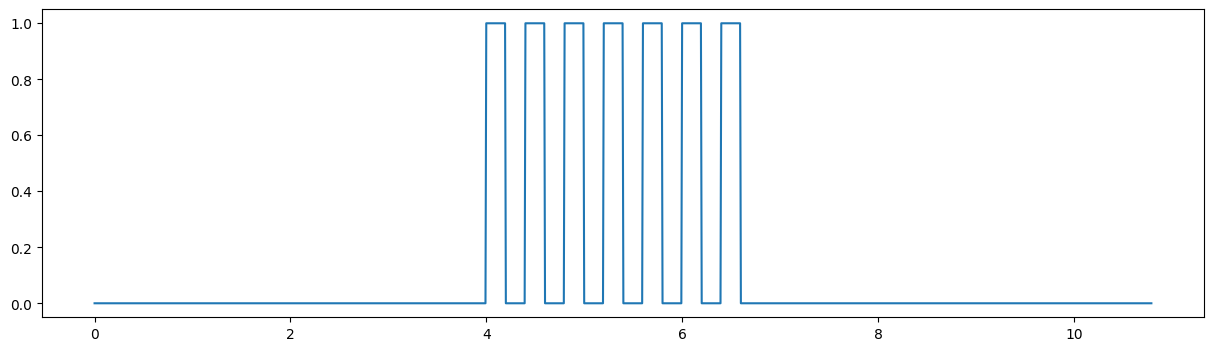

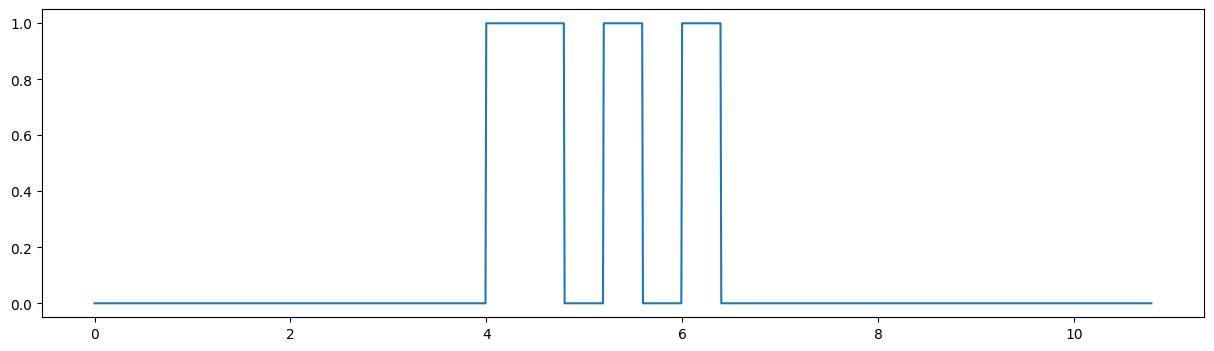

In [38]:
# single
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
# just generating csv for slow ctrl now
# csv is in format
# 	#1, #2, #3, ..., #18
#	b0_1, b0_2, b0_3, ..., b0_18
#	b1_1, b1_2, b1_3, ..., b1_18
#	...
#	b(N-1)_1, b(N-1)_2, b(N-1)_3, ..., b(N-1)_18
# using channel:
# 	#3 SLOW_CTRL_RESET_N
#	#4 SLOW_CTRL_IN
#	#2 SLOW_CTRL_CK
N_bit_slow_ctrl = 7
N_pixel = 1
N_bit_total = N_bit_slow_ctrl*N_pixel
timebase = 8 # ns
T_CK = 400 # ns
CK_T_SAMPLES = T_CK//timebase
total_time = T_CK*N_bit_total
CK_HITS = total_time//T_CK
print(f'Total time: {total_time}')

# IN_BITS = CSA_MODE_N0,CSA_MODE_N1,INJ_EN_N,SHAP_MODE1,SHAP_MODE0,CH_EN,INJ_MODE_N
# to be reversed
PIXEL_TO_TEST = 0
IN_BITS = [0,1,0,1,0,1,1]
if PIXEL_TO_TEST == 'all':
	IN_BITS_REV = IN_BITS[::-1]
	IN_BITSTREAM = IN_BITS_REV*N_pixel
else:
	IN_BITS_OFF = list.copy(IN_BITS)
	IN_BITS_OFF[2] = 1 # inj off for all channels
	IN_BITS_OFF_REV = IN_BITS_OFF[::-1]
	IN_BITSTREAM_OFF = IN_BITS_OFF_REV*N_pixel
	IN_BITSTREAM = IN_BITSTREAM_OFF
	IN_BITSTREAM[(N_pixel-1 - PIXEL_TO_TEST)*len(IN_BITS) + (len(IN_BITS)-1 - 2)] = 0 # inj on only on the one which we want

# everything needs to go to 0 except for reset_n, what really matters is that it is reset at the beginning
# so let's add some initialisation
N_INIT = 500
slow_ctrl_ck = [0]*N_INIT + ([1]*(CK_T_SAMPLES//2) + [0]*(CK_T_SAMPLES//2))*CK_HITS + [0]*N_INIT
slow_ctrl_reset_n = [0]*N_INIT + ([1]*CK_T_SAMPLES)*CK_HITS + [1]*N_INIT
slow_ctrl_in = [0]*N_INIT + list(np.array([[x]*CK_T_SAMPLES for x in IN_BITSTREAM]).flatten()) + [0]*N_INIT
print(f'Total length: {len(slow_ctrl_ck)}, {len(slow_ctrl_reset_n)}, {len(slow_ctrl_in)}')

plt.figure(figsize=(15,4))
plt.plot(np.arange(len(slow_ctrl_reset_n))*timebase/1000,slow_ctrl_reset_n)
plt.figure(figsize=(15,4))
plt.plot(np.arange(len(slow_ctrl_reset_n))*timebase/1000,slow_ctrl_ck)
plt.figure(figsize=(15,4))
plt.plot(np.arange(len(slow_ctrl_reset_n))*timebase/1000,slow_ctrl_in)

df = pd.DataFrame()
df['#2'] = slow_ctrl_ck
df['#3'] = slow_ctrl_reset_n
df['#4'] = slow_ctrl_in
df['#17'] = 0
df['#16'] = 0
conf_name = ''.join([str(x) for x in IN_BITS])